In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import noctiluca as nl

# MSD analysis
The mean squared displacement—MSD—is one of the most frequently used statistics on SPT data. ``noctiluca`` provides some functionality to calculate these. Note, however, that MSD analysis is statistically non-trivial (e.g. [Vestergaard et al.](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.89.022726) note that estimating diffusion coefficients from linear MSD fits is suboptimal). Thus, for production MSD analysis, we recommend [bayesmsd](https://github.com/OpenTrajectoryAnalysis/bayesmsd), a downstream analysis library building on ``noctiluca``.

In the language of ``bayesmsd``, the MSDs calculated by ``noctiluca`` are *empirical MSDs*, i.e. directly calculated from the raw data, using the formula
\begin{equation}
\text{MSD}(\Delta t) := \left\langle (x(t+\Delta t) - x(t))^2 \right\rangle_t\,.
\end{equation}
Let's see how this is done.

In [2]:
# Step 1: generate an example data set that we will use for the remainder of this example
# We use 100 standard random walk (i.e. simple diffusion) trajectories in 2D, with 100 data points per trajectory
data = nl.make_TaggedSet(np.cumsum(np.random.normal(size=(100, 100, 2)), axis=1))

  0%|          | 0/100 [00:00<?, ?it/s]

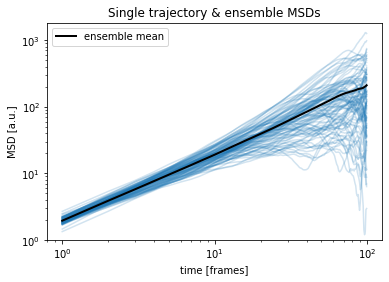

In [3]:
# Step 2: look at MSDs
nl.plot.msd_overview(tqdm(data), color='tab:blue', alpha=0.2)

plt.xlabel('time [frames]')
plt.ylabel('MSD [a.u.]')
plt.ylim([1, None])
plt.title('Single trajectory & ensemble MSDs')
plt.show()

Let's dissect what just happened:

+ in the first step we created an example data set. For more details on this, check the previous tutorials on [TaggedSet](02_TaggedSet.ipynb) and [I/O](03_IO.ipynb).
+ [msd_overview()](../noctiluca.rst#noctiluca.plot.msd_overview) is a function that generates plots like the one above. It is generally useful to get a quick overview over your dataset.
+ the actual MSD calculation is done by the ``nl.analysis`` module, which we will describe in more detail below; ``msd_overview()`` internally simply calls ``analysis.MSD()``.
+ ``msd_overview()`` allows some customization of the plot by forwarding all keyword arguments to the ``pyplot.plot()`` calls for the single trajectory MSDs. For more detailed customization, use the returned list of ``matplotlib.Line2D`` objects
+ note that we can use the nice progress bar provided by [tqdm](https://github.com/tqdm/tqdm) to keep tabs on the calculation while it is running; this comes in handy when working with large datasets

## More on [analysis.MSD()](../noctiluca.analysis.rst#noctiluca.analysis.p2.MSD)
As mentioned, the actual MSD calculation is performed by the ``nl.analysis`` module, which provides the ``MSD()`` function that can be used to calculate MSDs for single trajectories, or whole datasets:

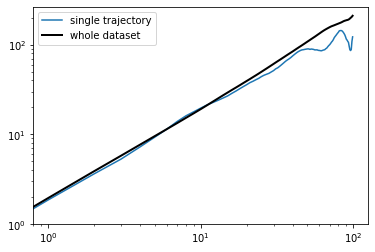

In [4]:
traj = data[0] # pick some trajectory
msd_traj = nl.analysis.MSD(traj)
msd_data = nl.analysis.MSD(data)

plt.loglog(msd_traj, color='tab:blue', label='single trajectory')
plt.loglog(msd_data, color='k', linewidth=2, label='whole dataset')
plt.ylim([1, None])
plt.legend()
plt.show()

If you are running this notebook live, you might have noticed that this time the calculation of the ensemble MSD was almost instant, while for the first plot it took about a second. What's different here?

``analysis.MSD()`` caches the MSD calculations it does for any ``Trajectory``—in that ``Trajectory``'s ``meta``-dict:

In [5]:
print("traj.meta:       ", traj.meta.keys())
print("traj.meta['MSD']:", traj.meta['MSD'].keys())
print()
print("nl.analysis.MSD(traj) is traj.meta['MSD']['data']:", nl.analysis.MSD(traj) is traj.meta['MSD']['data'])

traj.meta:        dict_keys(['MSD'])
traj.meta['MSD']: dict_keys(['N', 'data'])

nl.analysis.MSD(traj) is traj.meta['MSD']['data']: True


When ``nl.analysis.MSD()`` is called on a ``Trajectory``, it checks whether the ``meta['MSD']`` entry exists; if so, it skips the whole calculation and just returns the stored value. This means that once you calculate MSDs on all your trajectories, running downstream analyses (e.g. MSD grouped by different conditions) is fast. So don't feel bad about calling ``nl.analysis.MSD()`` on the same data 5 times in a row! It will do the actual calculation only once.

## Time averaging
By default, ``analysis.MSD()`` calculates a time-averaged MSD (TA-MSD). To prevent this:

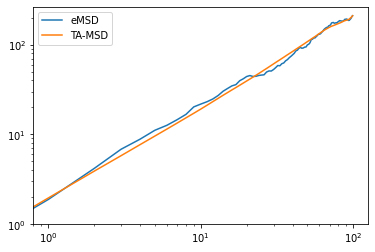

In [6]:
e_msd = nl.analysis.MSD(data, TA=False, recalculate=True)

plt.loglog(e_msd, label='eMSD')
plt.loglog(msd_data, label='TA-MSD') # this was calculated above

plt.ylim([1, None])
plt.legend()
plt.show()

In addition to ``TA=False``, note the use of ``recalculate=True``; with this switch ``MSD()`` will ignore cached values and just run the calculation in any case. Remember to use this when calculating MSDs with different settings for ``TA``!

## Parallelization
If the dataset in question is very large, calculating MSDs can take some time; we might want to run those calculations on multiple cores in parallel. ``noctiluca`` has the following mechanism for this:

In [7]:
# For this example, we only use n=1 processes, so not really parallelized
# Also note that chunksize can be an important parameter to actually
# achieve a speedup!
with nl.Parallelize(n=1, chunksize=10):
    msd = nl.analysis.MSD(data, recalculate=True)

The [nl.Parallelize](../noctiluca.rst#noctiluca.parallel.Parallelize) context manager provides a simple way to parallelize computations in certain ``noctiluca`` functions, without having to change anything else about your code; parallelization is taken care of under the hood.

Functions wrapped by this context manager need to be "aware" of this mechanism; note the corresponding statement in the [analysis.MSD()](../noctiluca.analysis.rst#noctiluca.analysis.p2.MSD) docstring.

The function ``TaggedSet.apply()``—demonstrated in the ``TaggedSet`` tutorial—is another parallel-aware function in ``noctiluca``.

# Other two-point functions
Using ``nl.analysis.MSD()`` in the examples above is actually a short-cut: under the hood, ``MSD()`` lives in ``nl.analysis.p2`` and is in fact just a simple call to ``nl.analysis.p2.P2()`` (which then in turn dispatches to ``p2.P2dataset()`` or ``p2.P2traj()``). What's all this?

The MSD is just one of various "two-point functions" that may be of interest for SPT analysis. Others include the autocovariance
\begin{equation}
\text{ACov}(\Delta t) := \left\langle x(t+\Delta t)x(t) \right\rangle_t\,,
\end{equation}
the velocity autocorrelation
\begin{equation}
\text{VACov}(\Delta t) := \left\langle v(t+\Delta t)v(t) \right\rangle_t \qquad v(t) \equiv x(t+\tau_\text{frame}) - x(t) \,,
\end{equation}

or other user-defined versions of these. ``noctiluca.analysis`` provides [MSD()](../noctiluca.analysis.rst#noctiluca.analysis.p2.MSD), [ACov()](../noctiluca.analysis.rst#noctiluca.analysis.p2.ACov), [VACov()](../noctiluca.analysis.rst#noctiluca.analysis.p2.VACov), [ACorr()](../noctiluca.analysis.rst#noctiluca.analysis.p2.ACorr) (auto*correlation*, i.e. normalized), and [VACorr()](../noctiluca.analysis.rst#noctiluca.analysis.p2.VACorr) (velocity auto*correlation*), all of which work pretty much exactly like demonstrated above for ``MSD()``. As an example, here are two ways to calculate the velocity autocorrelation for our diffusive dataset (expected to be delta-correlated):

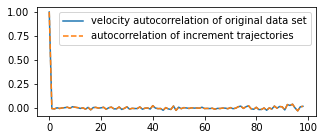

In [8]:
vacf0 = nl.analysis.VACorr(data)
vacf1 = nl.analysis.ACorr(data.apply(lambda traj: traj.diff()))

plt.figure(figsize=[5, 2])
plt.plot(vacf0, label='velocity autocorrelation of original data set')
plt.plot(vacf1, linestyle='--',
         label='autocorrelation of increment trajectories',
        )
plt.legend()
plt.show()

All of the functions mentioned above are implemented as special cases of a generic "two-point function" (the "two-point" referring to the fact that these are averages including two different time points along the trajectory):
\begin{equation}
\text{P2}(\Delta t) = \left\langle f\left(x(t+\Delta t), x(t)\right) \right\rangle_t\,,
\end{equation}
with different functions $f$ (and in the case of correlation functions also some normalization on each trajectory before taking the ensemble average).

You can define your own two-point function and take advantage of the full functionality implemented in ``P2()`` (such as parallelization of ensemble averages, time averaging or no, caching, etc.) by just specifying the function $f$. For example, here is the full definition of ``analysis.MSD()``:

In [9]:
def SD(x, y):
    return np.sum((x-y)**2, axis=-1)

def MSD(*args, **kwargs):
    return nl.analysis.p2.P2(*args, **kwargs, function=SD, writeto='MSD')

The last keyword ``writeto`` specifies which ``meta`` entry of the trajectories to use for caching the calculation.

For more details, read the documentation of [analysis.p2.P2traj()](../noctiluca.analysis.rst#noctiluca.analysis.p2.P2traj), [analysis.p2.P2dataset()](../noctiluca.analysis.rst#noctiluca.analysis.p2.P2dataset), and [analysis.p2.P2()](../noctiluca.analysis.rst#noctiluca.analysis.p2.P2)